In [1]:
!pip install janome japanize_matplotlib

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 4.1 MB 4.9 MB/s eta 0:00:01
  Created wheel for japanize-matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4122318 sha256=7df542ca2c646cb1ceb8a40f379e1c0eadb2a6d863160e0e021e70849e3add99
  Stored in directory: /home/tensorflow/.cache/pip/wheels/a7/cb/52/9f081a07b4b325c89f668591ef34b9cef79edd2990778c3134
Successfully built japanize-matplotlib
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [2]:
from tensorflow.keras.utils import get_file

url = 'https://github.com/odashi/small_parallel_enja/archive/master.zip'

zip_file_path = get_file('small_parallel_enja.zip', url, cache_subdir='small_parallel_enja', extract=True) 

In [3]:
import os

data_dir = os.path.join(os.path.dirname(zip_file_path), 'small_parallel_enja-master')
!ls -l $data_dir

total 9076
-rw-r--r-- 1 tensorflow tensorflow    1946 Feb 10 01:12 README.md
-rw-r--r-- 1 tensorflow tensorflow   17054 Feb 10 01:12 dev.en
-rw-r--r-- 1 tensorflow tensorflow   27781 Feb 10 01:12 dev.ja
-rw-r--r-- 1 tensorflow tensorflow   17301 Feb 10 01:12 test.en
-rw-r--r-- 1 tensorflow tensorflow   27793 Feb 10 01:12 test.ja
-rw-r--r-- 1 tensorflow tensorflow 1701356 Feb 10 01:12 train.en
-rw-r--r-- 1 tensorflow tensorflow  339768 Feb 10 01:12 train.en.000
-rw-r--r-- 1 tensorflow tensorflow  340186 Feb 10 01:12 train.en.001
-rw-r--r-- 1 tensorflow tensorflow  341174 Feb 10 01:12 train.en.002
-rw-r--r-- 1 tensorflow tensorflow  339953 Feb 10 01:12 train.en.003
-rw-r--r-- 1 tensorflow tensorflow  340275 Feb 10 01:12 train.en.004
-rw-r--r-- 1 tensorflow tensorflow   30025 Feb 10 01:12 train.en.vocab.4k
-rw-r--r-- 1 tensorflow tensorflow   51162 Feb 10 01:12 train.en.vocab.all
-rw-r--r-- 1 tensorflow tensorflow 2784447 Feb 10 01:12 train.ja
-rw-r--r-- 1 tensorflow tensorflow  556444 Fe

In [4]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences

def load_data(path):
    tokenizer = Tokenizer(filters='')
    
    texts = []
    for line in open(path, 'r'):
        texts.append('<start> ' + line.strip() + ' <end>')
    
    tokenizer.fit_on_texts(texts)
    return tokenizer.texts_to_sequences(texts), tokenizer

en, inp_lang = load_data(os.path.join(data_dir, 'train.en'))
ja, targ_lang = load_data(os.path.join(data_dir, 'train.ja'))

vocab_inp_size = len(inp_lang.word_index) + 1
vocab_tar_size = len(targ_lang.word_index) + 1

train_en, test_en, train_ja, test_ja = train_test_split(en, ja, test_size=0.1, random_state=36)

input_tensor_train = pad_sequences(train_en, padding='post')
target_tensor_train = pad_sequences(train_ja, padding='post')
input_tensor_val = pad_sequences(test_en, padding='post')
target_tensor_val = pad_sequences(test_ja, padding='post')

max_length_inp = len(input_tensor_train[0])
max_length_targ = len(target_tensor_train[0])

In [5]:
def convert(lang, tensor):
    for t in tensor:
        if t!=0:
            print ("%d ----> %s" % (t, lang.index_word[t]))

In [6]:
print ("Input Language; index to word mapping")
convert(inp_lang, input_tensor_train[0])
print ()
print ("Target Language; index to word mapping")
convert(targ_lang, target_tensor_train[0])

Input Language; index to word mapping
1 ----> <start>
5 ----> i
512 ----> walked
12 ----> in
4 ----> the
2801 ----> woods
51 ----> by
410 ----> myself
3 ----> .
2 ----> <end>

Target Language; index to word mapping
1 ----> <start>
17 ----> 私
4 ----> は
265 ----> 一人
11 ----> で
1571 ----> 森
8 ----> を
198 ----> 歩
5 ----> い
7 ----> た
3 ----> 。
2 ----> <end>


In [9]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64
steps_per_epoch = len(input_tensor_train) // BATCH_SIZE
embedding_dim = 256
units = 1024
vocab_inp_size = len(inp_lang.word_index)+1
vocab_tar_size = len(targ_lang.word_index)+1

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [10]:
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([64, 18]), TensorShape([64, 18]))

In [11]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
        super(Encoder, self).__init__()
        self.batch_sz = batch_sz
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.enc_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')

    def call(self, x, hidden):
        x = self.embedding(x)
        output, state = self.gru(x, initial_state = hidden)
        return output, state

    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.enc_units))

In [12]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

# サンプル入力
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

Encoder output shape: (batch size, sequence length, units) (64, 18, 1024)
Encoder Hidden state shape: (batch size, units) (64, 1024)


In [13]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, query, values):
        # hidden shape == (batch_size, hidden size)
        # hidden_with_time_axis shape == (batch_size, 1, hidden size)
        # スコアを計算するためにこのように加算を実行する
        hidden_with_time_axis = tf.expand_dims(query, 1)

        # score shape == (batch_size, max_length, 1)
        # スコアを self.V に適用するために最後の軸は 1 となる
        # self.V に適用する前のテンソルの shape は  (batch_size, max_length, units)
        score = self.V(tf.nn.tanh(
                      self.W1(values) + self.W2(hidden_with_time_axis)))

        # attention_weights の shape == (batch_size, max_length, 1)
        attention_weights = tf.nn.softmax(score, axis=1)

        # context_vector の合計後の shape == (batch_size, hidden_size)
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

In [14]:
attention_layer = BahdanauAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape: (batch size, units) (64, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (64, 18, 1)


In [15]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
        super(Decoder, self).__init__()
        self.batch_sz = batch_sz
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.dec_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
        self.fc = tf.keras.layers.Dense(vocab_size)

        # アテンションのため
        self.attention = BahdanauAttention(self.dec_units)

    def call(self, x, hidden, enc_output):
        # enc_output の shape == (batch_size, max_length, hidden_size)
        context_vector, attention_weights = self.attention(hidden, enc_output)

        # 埋め込み層を通過したあとの x の shape  == (batch_size, 1, embedding_dim)
        x = self.embedding(x)

        # 結合後の x の shape == (batch_size, 1, embedding_dim + hidden_size)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

        # 結合したベクトルを GRU 層に渡す
        output, state = self.gru(x)

        # output shape == (batch_size * 1, hidden_size)
        output = tf.reshape(output, (-1, output.shape[2]))

        # output shape == (batch_size, vocab)
        x = self.fc(output)

        return x, state, attention_weights

In [16]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

sample_decoder_output, _, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                      sample_hidden, sample_output)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (64, 8777)


In [17]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
                             from_logits=True, reduction='none')
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

In [18]:
import os

checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

In [19]:
@tf.function
def train_step(inp, targ, enc_hidden):
    loss = 0

    with tf.GradientTape() as tape:
        enc_output, enc_hidden = encoder(inp, enc_hidden)

        dec_hidden = enc_hidden

        dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)

        # Teacher Forcing - 正解値を次の入力として供給
        for t in range(1, targ.shape[1]):
            # passing enc_output to the decoder
            predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

            loss += loss_function(targ[:, t], predictions)

            # Teacher Forcing を使用
            dec_input = tf.expand_dims(targ[:, t], 1)

    batch_loss = (loss / int(targ.shape[1]))

    variables = encoder.trainable_variables + decoder.trainable_variables

    gradients = tape.gradient(loss, variables)

    optimizer.apply_gradients(zip(gradients, variables))

    return batch_loss

In [20]:
import time

EPOCHS = 20

for epoch in range(EPOCHS):
    start = time.time()

    enc_hidden = encoder.initialize_hidden_state()
    total_loss = 0

    for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
        batch_loss = train_step(inp, targ, enc_hidden)
        total_loss += batch_loss

        if batch % 100 == 0:
              print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                     batch,
                                                     batch_loss.numpy()))
    # 2 エポックごとにモデル（のチェックポイント）を保存
    if (epoch + 1) % 2 == 0:
        checkpoint.save(file_prefix = checkpoint_prefix)

    print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 6.3765
Epoch 1 Batch 100 Loss 3.0597
Epoch 1 Batch 200 Loss 2.5167
Epoch 1 Batch 300 Loss 2.2917
Epoch 1 Batch 400 Loss 2.2028
Epoch 1 Batch 500 Loss 2.1766
Epoch 1 Batch 600 Loss 2.0911
Epoch 1 Batch 700 Loss 1.9589
Epoch 1 Loss 2.4357
Time taken for 1 epoch 60.129674196243286 sec

Epoch 2 Batch 0 Loss 1.9059
Epoch 2 Batch 100 Loss 1.9439
Epoch 2 Batch 200 Loss 1.9318
Epoch 2 Batch 300 Loss 1.8377
Epoch 2 Batch 400 Loss 1.8810
Epoch 2 Batch 500 Loss 1.7346
Epoch 2 Batch 600 Loss 1.7172
Epoch 2 Batch 700 Loss 1.6921
Epoch 2 Loss 1.8101
Time taken for 1 epoch 48.92658710479736 sec

Epoch 3 Batch 0 Loss 1.6115
Epoch 3 Batch 100 Loss 1.5813
Epoch 3 Batch 200 Loss 1.6009
Epoch 3 Batch 300 Loss 1.4711
Epoch 3 Batch 400 Loss 1.3869
Epoch 3 Batch 500 Loss 1.4878
Epoch 3 Batch 600 Loss 1.5108
Epoch 3 Batch 700 Loss 1.4103
Epoch 3 Loss 1.4890
Time taken for 1 epoch 48.615049600601196 sec

Epoch 4 Batch 0 Loss 1.1864
Epoch 4 Batch 100 Loss 1.1660
Epoch 4 Batch 200 Loss 1.132

In [37]:
def predict(inputs):
    inputs = tf.convert_to_tensor(inputs)
    predicted_seq = []
    
    hidden = [tf.zeros((1, units))]
    enc_out, enc_hidden = encoder(inputs, hidden)

    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)

    for t in range(max_length_targ):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)

        # 後ほどプロットするためにアテンションの重みを保存
        attention_weights = tf.reshape(attention_weights, (-1, ))

        predicted_id = tf.argmax(predictions[0]).numpy()

        predicted_seq.append(predicted_id)

        if targ_lang.index_word[predicted_id] == '<end>':
            return predicted_seq

        # 予測された ID がモデルに戻される
        dec_input = tf.expand_dims([predicted_id], 0)

    return predicted_seq
    

In [30]:
import numpy as np

def evaluate(sentence):
    attention_plot = np.zeros((max_length_targ, max_length_inp))

    sentence = preprocess_en(sentence)

    inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                           maxlen=max_length_inp,
                                                           padding='post')
    inputs = tf.convert_to_tensor(inputs)

    result = ''

    hidden = [tf.zeros((1, units))]
    enc_out, enc_hidden = encoder(inputs, hidden)

    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)

    for t in range(max_length_targ):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)

        # 後ほどプロットするためにアテンションの重みを保存
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()

        result += targ_lang.index_word[predicted_id] + ' '

        if targ_lang.index_word[predicted_id] == '<end>':
            return result, sentence, attention_plot

        # 予測された ID がモデルに戻される
        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention_plot

In [31]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import japanize_matplotlib

# アテンションの重みをプロットする関数
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

In [32]:
def translate(sentence):
    result, sentence, attention_plot = evaluate(sentence)

    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))

    attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
    plot_attention(attention_plot, sentence.split(' '), result.split(' '))

In [33]:
# checkpoint_dir の中の最後のチェックポイントを復元
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

Input: <start> it is necessary that the bill pass the diet . <end>
Predicted translation: あなた は その 人 は もう 一 人 だ と 、 私 より も いい です ね 。 <end> 


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  


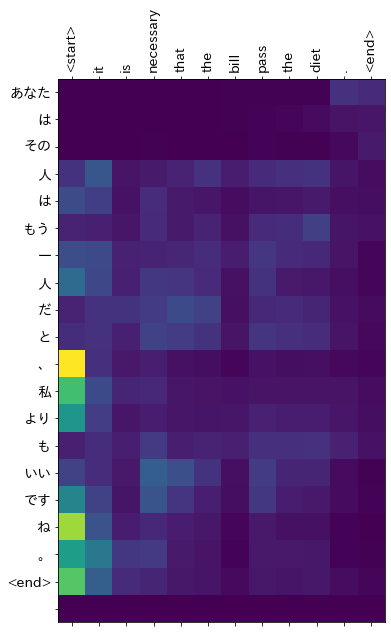

In [34]:
translate('It is necessary that the bill pass the diet.')

In [38]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

bleu_scores = []
for i, input_en in enumerate(input_tensor_val):
    predicted_ja = predict(input_en)
    tokens_input = [inp_lang.index_word[id] for id in input_en if id > 2]
    tokens_target = [targ_lang.index_word[id] for id in target_tensor_val[i] if id > 2]
    tokens_predicted = [targ_lang.index_word[id] for id in predicted_ja if id > 2]
    bleu_score = sentence_bleu(tokens_target, tokens_predicted)
    bleu_scores.append(bleu_score)
    print('Source:{}'.format(' '.join(tokens_input)))
    print('Target:{}'.format(''.join(tokens_target)))
    print('Prediction:{}'.format(''.join(tokens_predicted)))
    print('BLEU score:', bleu_score)
    print()
    
avg_bleu = np.average(bleu_scores)
print('Average BLEU:', avg_bleu)

/home/tensorflow/.local/lib/python3.6/site-packages/nltk/translate/bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/tensorflow/.local/lib/python3.6/site-packages/nltk/translate/bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/tensorflow/.local/lib/python3.6/site-packages/nltk/translate/bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use S

Source:place your skis in an inverted v .
Target:あなたのスキーを逆v字型にしなさい。
Prediction:お医者さんの方があいている。[m]
BLEU score: 1.1409851298103347e-231

Source:hope you'll have a great one .
Target:いい誕生日を迎えられますように。
Prediction:お年寄りはいくつか意見が悪いのです。
BLEU score: 1.0003688322288243e-231

Source:will you show me what you bought yesterday ?
Target:あなたが昨日買ったものを見せてくれませんか。
Prediction:あなたが私に貸してくれませんか。
BLEU score: 1.4959003140449574e-231

Source:you were in the second year of middle school last year , right ?
Target:あなたがたは去年中学2年生でしたね。
Prediction:3の間の間の数の数の数の数の数の数の数の数の数の数の数の数の数の数の数の数の数の数の数の数の数の数の数の数の数の数の数の数の数の数の
BLEU score: 0

Source:we expected we should have a warm january , but we hear that this winter is the coldest in twenty years .
Target:1月は暖かいだろうと思っていたが、この冬は20年ぶりの寒さだそうだ。
Prediction:ある国の厚い日、3日以内で調べてくれたので、その施設ができないので、その施設ができないので、その施設ができないので、その施設ができないので、その施設ができないので、その施設ができないので、その施設ができないので、その
BLEU score: 9.557951902988592e-232

Source:this fried egg tastes like a sheet of rubber .
Target:このフライドエッグは、ゴムのような味がする。
Pred